# Stackoverflow Developer Survey: Data Scientist Technology Radar

## Introduction and Methodology

The goal of this project is to use a publicly available data set to answer three questions following the CRISP-DM process. Thus, this analysis follows the CRISP-DM process steps, namely:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modelling
5. Result Evaluation
6. Deployment

After discussing steps 1 and 2 to arrive at the research questions to be answered, and step 3 to prepare for analysis, steps 4 and 5 are repeated for each question. Step 6 is going to be addressed by discussing the results in a Medium Blog Post and making the analysis available on GitHub.

## 1. Business Understanding

Using the Stackoverflow Developer Survey Data from 2020 as well as earlier years, the following questions on the use of programming languages by the survey respondents are going to be addressed:

1. Which programming languages are currently being used?
2. How has this changed over the past years?
3. Which programming languages are the respondents aspiring to use in the future?

As an aspiring Data Scientist myself, I am most interested in the programming languages trends among professional Data Scientists, so I am going to focus on this particular subgroup throughout my analyses.


## 2. Data Understanding

To get started, let's first load the necessary libraries and import the 2020 data:

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../developer_survey/developer_survey_2020/survey_results_public.csv')
df_schema = pd.read_csv('../developer_survey/developer_survey_2020/survey_results_schema.csv')

df.shape

(64461, 61)

For 2020, the survey data consist of 64,461 responses to 61 questions.

Throughout this project, I am interested in survey responses on programming languages used by professional Data Scientists. Thus, I focus on two questions of the Stackoverflow Developer Survey: LanguageWorkedWith for information on used programming languages and DevType to identify Data Scientists in the overall sample. First, let's look at the question text and some example answers!

In [3]:
print('Languages: \n', list(df_schema[df_schema.Column == 'LanguageWorkedWith']['QuestionText'])[0], 
      '\n\nDeveloper Type: \n', list(df_schema[df_schema.Column == 'DevType']['QuestionText'])[0])

Languages: 
 Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.) 

Developer Type: 
 Which of the following describe you? Please select all that apply.


In [4]:
df[['LanguageWorkedWith', 'DevType']].head()

,LanguageWorkedWith,DevType
0,C#;HTML/CSS;JavaScript,"Developer, desktop or enterprise applications;..."
1,JavaScript;Swift,"Developer, full-stack;Developer, mobile"
2,Objective-C;Python;Swift,NaN
3,NaN,NaN
4,HTML/CSS;Ruby;SQL,NaN


## 3. Data Preparation

To see how widespread the different technologies are among Data Scientists in particular, some cleanups need to be performed.

First, let's select a subset of the data to focus on Data Scientists by searching through the DevType answers:

In [5]:
df = df[df['DevType'].notnull()]
df = df[df['DevType'].str.contains("Data scientist")]

df.shape

(3988, 61)

Now I can focus on preparing the language data: In case of multiple responses, all of those have been concatenated, which needs to be corrected!
In addition, responses need to be counted and transformed into percentages for better comparability. 

To this end, here is a function helping me to perform the necessary actions to arrive at a cleaned dataframe holding the information I am interested in:

In [6]:
def clean_technology(df, colname, techname):
    '''
    INPUT 
        df - a dataframe holding the desired column
        colname - string name of the column
        techname - string name of the type of technology in the column
        
    OUTPUT
        tech_df - a dataframe with all technologies and relative frequency per technology
    '''
    technologies = df[df[colname].notnull()]
    with pd.option_context('mode.chained_assignment', None):
        technologies[colname] = technologies[colname].str.replace(' ', '')
    possible_techs = {}
    
    for technology_set in technologies[colname].apply(lambda row: str(row).split(';')):
        for technology in technology_set:
            if technology not in possible_techs.keys():
                possible_techs[technology] = 1
            else:
                possible_techs[technology] +=1
    
    possible_techs.update((x, y/len(technologies)) for x, y in possible_techs.items())

    possible_techs = {k: possible_techs[k] for k in sorted(possible_techs, key=possible_techs.get, reverse=True)}
    
    tech_df = pd.DataFrame.from_dict(possible_techs, orient='index').reset_index()
    tech_df.rename(columns={'index': techname, 0: 'perc'}, inplace=True)
    
    return tech_df

## Question 1:  Which programming languages are currently being used?

### 4. Data Modelling

Now, I am able to use the functions to investigate technology use in 2020. To grasp the distribution quickly, I use a simple bar graph that can be produced with the following function:

In [7]:
def plot_technology_usage(df, techname, valname, title):
    '''
    INPUT 
        df - a dataframe holding the desired columns
        techname - string name of the type of technology in the column
        valname - string name of the value column
        
    OUTPUT
        Displays a plot of the propensities of technologies
    '''
    plot = plt.bar(df[techname], df[valname]);
    plt.xticks(rotation=90);
    plt.title(title)
    return plt

,language,perc
0,Python,0.834848
1,SQL,0.622929
2,JavaScript,0.514431
3,HTML/CSS,0.514164
5,Java,0.373597
7,R,0.294495


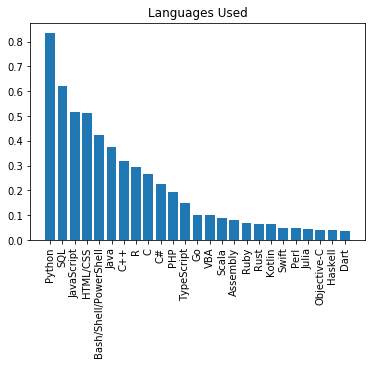

In [8]:
current_tech_df = clean_technology(df, 'LanguageWorkedWith', 'language')
plot = plot_technology_usage(current_tech_df, 'language', 'perc', title='Languages Used')
plot.savefig('./images/current_languages.png', bbox_inches='tight')

current_tech_df[current_tech_df['language'].isin(['Python', 'SQL', 'JavaScript', 'HTML/CSS', 'Java', 'R'])]

### 5. Result Evaluation

JavaScript and HTML/CSS are the most widely used languages. Good news for aspiring Data Scientists: SQL and Python are very widely used as well, even more than traditional languages like Java!

## Question 2: How does the popularity of programming languages change over time?

Now that I am familiar with the variable I want to look at here, let's make it more interesting and see how the popularity of languages used has changed over the years.

### 4. Data Modelling

To investigate my second question, I need more information than only 2020. Thus, I have to add information from previous years to my data frame. To arrive at the data I need, I am going to do the following:

* Load the data set for a year
* Clean the data set as before
* Add a column indicating the year

Here is a function to help do this for the used programming languages, focusing on Data Scientists:

In [9]:
def yearly_language_numbers(year):
    '''
    INPUT
        year - the year of the survey
    
    OUTPUT
        df_year - cleaned data set for the specified year
    '''    
    if year >= 2017:
        df_year = pd.read_csv(f"../developer_survey/developer_survey_{year}/survey_results_public.csv", low_memory=False)
        
        
        if year!=2017:
            df_year = df_year[df_year['DevType'].notnull()]
            df_year = df_year[df_year['DevType'].str.contains("Data scientist")]
            df_year = clean_technology(df_year, 'LanguageWorkedWith', 'language')
        else:
            df_year = df_year[df_year['DeveloperType'].notnull()]
            df_year = df_year[df_year['DeveloperType'].str.contains("Data scientist")]
            df_year = clean_technology(df_year, 'HaveWorkedLanguage', 'language')
        
    else:
        df_year = pd.read_csv(f"../developer_survey/developer_survey_{year}/{year} Stack Overflow Survey Responses.csv")
        df_year = df_year[df_year['occupation'].notnull()]
        df_year = df_year[df_year['occupation'].str.contains("Data scientist")]
        df_year = clean_technology(df_year, 'tech_do', 'language')
    
    df_year['year'] = year
    
    return df_year

Let's try whether this gives me the desired data for a year:

In [10]:
df_2016 = yearly_language_numbers(2016)
df_2016.head()

,language,perc,year
0,Python,0.640152,2016
1,SQL,0.449495,2016
2,R,0.444444,2016
3,Java,0.303030,2016
4,JavaScript,0.261364,2016


Looks good so far!

Now, to be able to look at time trends, let's merge all of the cleaned data frames, again with the help of a function:

In [11]:
def language_perc_over_time(years):
    '''
    INPUT
        years - list of ints with years of the survey that should be considered
    
    OUTPUT
        df_concat - combined cleaned data set
    '''
    df_concat = pd.DataFrame()
    for year in years:
        df_year = yearly_language_numbers(year)
        df_concat = pd.concat([df_concat, df_year], ignore_index=True)
    
    df_concat = df_concat.pivot(index='year', columns='language', values='perc')
        
    return df_concat

Great, let's do the actual work. This might take a while...

In [12]:
df_timetrend = language_perc_over_time([2016,2017,2018,2019,2020])

In [13]:
df_timetrend

language,Android,AngularJS,Arduino/RaspberryPi,Assembly,Bash/Shell,Bash/Shell/PowerShell,C,C#,C++,CSS,...,Swift,TypeScript,VB.NET,VBA,VisualBasic,VisualBasic6,WebAssembly,WindowsPhone,WordPress,iOS
year,,,,,,,,,,,,,,,,,,,,,
2016,0.07702,0.051768,0.07702,NaN,NaN,NaN,0.157828,0.111111,0.195707,NaN,...,0.021465,NaN,NaN,NaN,0.055556,NaN,NaN,0.012626,0.041667,0.027778
2017,NaN,NaN,NaN,0.066372,NaN,NaN,0.232301,0.338496,0.300442,NaN,...,0.067257,0.098230,0.073894,0.075221,NaN,0.042920,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,0.106564,0.517956,NaN,0.313012,0.253382,0.365626,0.524303,...,0.064306,0.105061,0.060965,0.072657,NaN,0.042759,NaN,NaN,NaN,NaN
2019,NaN,NaN,NaN,0.088378,NaN,0.449554,0.261849,0.228844,0.323166,NaN,...,0.051150,0.133896,NaN,0.076646,NaN,NaN,0.018927,NaN,NaN,NaN
2020,NaN,NaN,NaN,0.080171,NaN,0.421700,0.266970,0.227418,0.317477,NaN,...,0.049973,0.149118,NaN,0.099412,NaN,NaN,NaN,NaN,NaN,NaN


Now, we have a data frame holding five years of data for a total of 66 programming languages.

However, the possible choices of language in the survey have changed over the past five years, so we face the problem that for some languages, values are not available for all five years.

In [14]:
language_obs_count = df_timetrend.count().reset_index()
language_obs_count.rename(columns={0: 'count'}, inplace=True)

print('Number of languages present in all five years:', len(language_obs_count[language_obs_count['count']==5]),
     '\nNumber of languages present in four years:', len(language_obs_count[language_obs_count['count']==4]),
     '\nNumber of languages present in three years:', len(language_obs_count[language_obs_count['count']==3]),
     '\nNumber of languages present in two years:', len(language_obs_count[language_obs_count['count']==2]),
     '\nNumber of languages present in one year:', len(language_obs_count[language_obs_count['count']==1]))

Number of languages present in all five years: 15 
Number of languages present in four years: 8 
Number of languages present in three years: 5 
Number of languages present in two years: 8 
Number of languages present in one year: 30


There are actually quite a few languages that do not appear as choice in every year of the survey!

To decide how to proceed with missings in this case, two arguments are important:

* The analysis should focus on languages that are still relevant today, so everything that is only present in earlier years will be discarded
* If there are more missings present than actual data points, imputation infers too much, especially as I am interested in time trends here, so all languages that are only present less than three years will be discarded as well

So first, let's drop all languages that are not present in 2020 and those that are present in less than three years from the data:

In [15]:
df_timetrend = df_timetrend.dropna(axis=1, subset=[2020])
df_timetrend = df_timetrend.dropna(axis=1, thresh=3)
df_timetrend.shape

(5, 23)

After these drops, 21 languages remain! To fill the gaps those with missings in between, I use linear extrapolation to reflect time trends in my data:

In [16]:
df_timetrend = df_timetrend.interpolate()

Now that the data is cleaned, we can plot time trends.

In [17]:
def plot_timetrend(df):
    '''
    INPUT
        df - a dataframe holding the data to be plotted
    OUTPUT
        a line plot of the data
    '''
    df.plot(marker='o')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(np.arange(2016, 2021, step=1), ('2016', '2017', '2018', '2019', '2020'))
    
    return plt

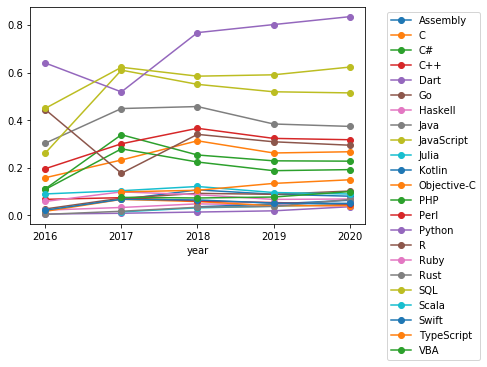

In [18]:
plot_timetrend(df_timetrend).show()


At first glance, usage seems to be pretty stable for most of the languages over the last five years (except for Python and R, both of which have a dip for 2017) - but there are many languages in the plot, especially at the bottom, so it might well be that variations cannot be seen very clearly in this plot. Thus, let's delve deeper by creating subplots.

Let's take a closer look at the most widely used languages among Data Scientists and at the least popular languages to identify weaker trends that might not be visible in the overall graph:

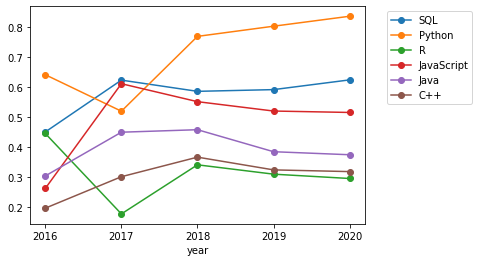

In [19]:
plot_1 = plot_timetrend(df_timetrend[['SQL', 'Python', 'R', 'JavaScript', 'Java', 'C++']])
plot.savefig('./images/languages_trend_most.png', bbox_inches='tight')

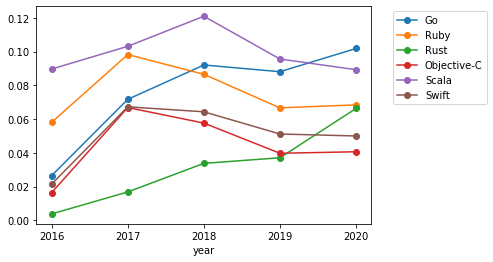

In [20]:
plot_2 = plot_timetrend(df_timetrend[['Go', 'Ruby', 'Rust', 'Objective-C', 'Scala', 'Swift']])
plot.savefig('./images/languages_trend_least.png', bbox_inches='tight')

### 5. Result Evaluation

While SQL is the most common language with a slight upwards trend, Phython seems to have won the race against R in the last years: while both had the same frequency of occurence in 2016, Phython usage has increased since then while R usage has declined.

Among the least common languages, two are especially noteworthy: Rust and Go. For both, a clear upwards trend is visible. Even though they might not be common yet, one day they might well be!

## Question 3: Which programming languages are the respondents aspiring to use in the future?

Now that I have looked into what survey respondents are using now and how these trends have changed over the past few years, let's focus on the future for the last question and explore which technologies the respondents aspire to use in the upcoming year.

### 4. Data Modelling

What do the respondents want to focus on next year?

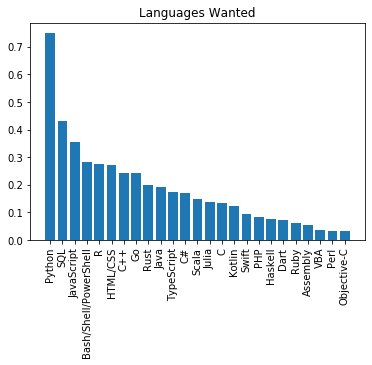

In [21]:
future_tech_df = clean_technology(df, 'LanguageDesireNextYear', 'language')
plot_technology_usage(future_tech_df, 'language', 'perc', title='Languages Wanted')
plot.savefig('./images/wanted_languages.png', bbox_inches='tight')

Let's see whether we can compare the languages used and those wanted more directly. For this, three additional functions come in handy:

In [22]:
def compare_tech_percs(now_df, wanted_df, technology):
    now_df = now_df.rename(columns={'perc': 'perc_now'})
    wanted_df = wanted_df.rename(columns={'perc': 'perc_future'})
    both_df = pd.merge(now_df, wanted_df, on=technology)
    both_df['perc_diff'] = both_df['perc_future']-both_df['perc_now']
    
    return both_df


def plot_both_tech_percs(both_df, technology):
    
    x = np.arange(len(both_df[technology]))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width/2, both_df['perc_now'], width, label='Now')
    ax.bar(x + width/2, both_df['perc_future'], width, label='Wanted')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(both_df[technology])
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.legend()

    return plt


def plot_perc_diff(both_df, technology):
    
    both_df = both_df.sort_values(by=['perc_diff'], ascending=False)
    plt.bar(both_df[technology], both_df['perc_diff']);
    plt.xticks(rotation=90);
    
    return plt

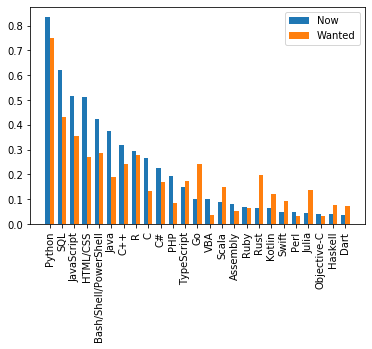

In [23]:
language_df = compare_tech_percs(current_tech_df, future_tech_df, 'language')
plot_both_tech_percs(language_df, 'language').show()

Alternatively, let's directly plot the difference:

,language,perc_now,perc_future,perc_diff
0,Python,0.834848,0.750281,-0.084566
1,SQL,0.622929,0.432227,-0.190702
7,R,0.294495,0.277278,-0.017217
12,Go,0.101817,0.241845,0.140028
17,Rust,0.066275,0.199100,0.132825
21,Julia,0.045163,0.139201,0.094038


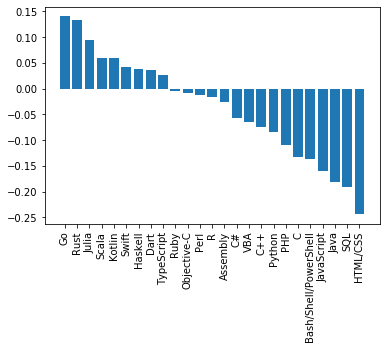

In [24]:
plot_perc_diff(language_df, 'language')
plot.savefig('./images/diff_languages.png', bbox_inches='tight')
language_df[language_df['language'].isin(['Go', 'Rust', 'Julia', 'Python', 'SQL', 'R'])]

### 5. Result Evaluation

To sum up, Python seems to be the most wanted language for Data Scientists in 2021 by far.

When comparing fractions of Data Scientist already using a language with those wanting to use it, you can see that Go and Rust, which we identified as up and coming among the least common languages, are actually even more wanted than used - most likely, the upwards trend for those is going to continue. Interestingly, Julia comes in third.